* @file     : Time Series Analysis.ipynb
* @author   : Sinan KAMILCELEBI
* @version  : V1.0.0
* @date     : 15-May-2019
* @brief    : Time Series Analysis (ARIMA) Example.

# Zaman Serileri Analizi

__Bu uygulamada mobilya satışları için zaman serisi analizi ve tahmini yapacağız.__

Kullanılan veri kümesi: https://community.tableau.com/docs/DOC-1236   

Veri kümesi coğrafi yer olarak Kanada konumunu içermekte olup "Superstore" satış verilerinde çeşitli kategorilerde örnekler vardır. Her bir kategoriye ait alt kategoriler de mevcuttur.                                                     

__Mobilya__ kategorisinde bulunan bazı alt kategoriler:    
> Sandalye   
Tablolar   
...  

__Ofis Malzemeleri__ kategorisinde bulunan bazı alt kategoriler:    
> Zarflar  
Kâğıt   
...  

__Teknoloji__ kategorisinde bulunan bazı alt kategoriler:    
> Telefonlar   
Aksesuarlar   
...  


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

Biz iyi bir __4 yıllık__ mobilya satış verisine sahibiz.

In [3]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [4]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Veri ön işleme (Data preprocessing)

Bu adım ihtiyacımız olmayan sütunları kaldırmayı, eksik değerleri kontrol etmeyi, tarihe göre toplam satışları vb. içerir. Veri kümesindeki ihtiyacımız olan verilerde ayrıştırma/seçim yapılmaktadır.

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis = 1, inplace = True)
furniture = furniture.sort_values('Order Date')

In [6]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture.head()

Order Date     Sales
0 2014-01-06  2573.820
1 2014-01-07    76.728
2 2014-01-10    51.940
3 2014-01-11     9.940
4 2014-01-13   879.939

## Zaman serisi verileri ile indeksleme 

In [9]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Mevcut datetime verilerimizle çalışmak zor olabilir. Bu nedenle biz bunun yerine o ay için ortalama günlük satış değerini kullanacağız ve her ayın başlangıcını timestamp olarak kullanıyoruz.

In [10]:
y = furniture['Sales'].resample('MS').mean()

2017 satış verilerine hızlı bir göz atalım.

In [11]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Mobilya satış zaman serisi verilerini görselleştirme 

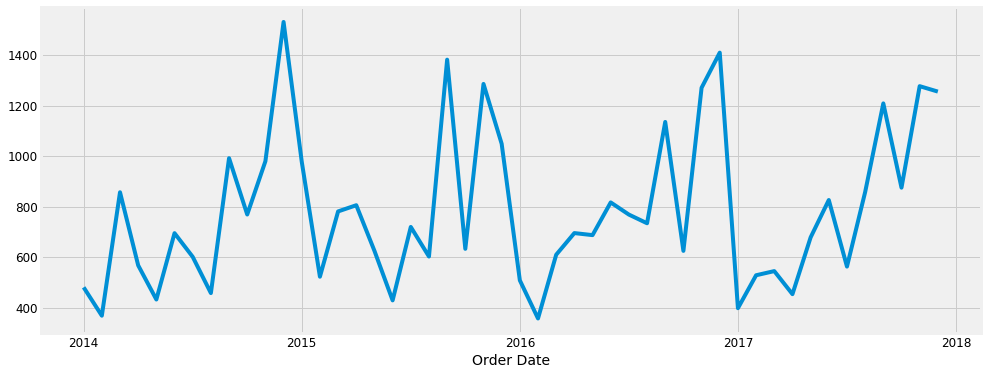

In [12]:
y.plot(figsize = (15, 6))
plt.show()

Verileri çizdiğimizde bazı ayırt edilebilir modeller ortaya çıkar. Zaman serileri mevsimsellik modeline (seasonality pattern) sahiptir. Örneğin satışlar yılın başında her zaman düşük ve yılın sonunda ise yüksektir. Yılın ortasında birkaç düşük ay ile herhangi bir yıl içinde güçlü bir artış (yükseliş) eğilim ilişkisi her zaman vardır.

Trend, mevsimsellik (seasonality) ve gürültü (noise): Verilerimizi üç ayrı zaman serisi bileşenlerine ayırmamızı sağlayan "zaman serisi ayrıştırma" da denilen bir metod kullanarak da görselleştirebiliriz. 

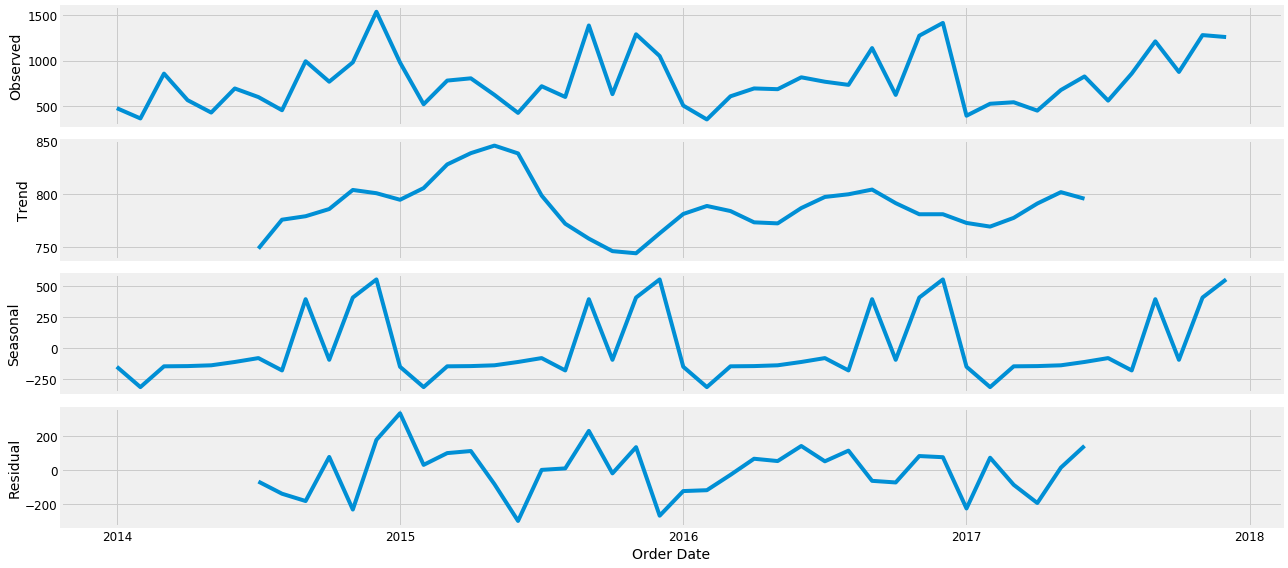

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

Yukarıdaki grafik mobilya satışlarının açık mevsimsellik ile birlikte __kararsız__ olduğunu göstermektedir.

## ARIMA ile zaman serileri tahmini

__"Autoregressive Integrated Moving Average"__ anlamına gelen ARIMA olarak da bilinen zaman serisi tahmini için en yaygın kullanılan yöntemlerden birini uygulayacağız.   

ARIMA modeli AR, MA ve I kısımlarından oluşmuştur. I bağımsız değişkeninin hangi seviyede durağan olduğunu göstermektedir.   

ARIMA ile zaman serisi modelini oluştururken uygun model seviyesini belirlemek için 3 parametre seçmeliyiz. Bu parametreler sırasıyla; p, d ve q dir. Ve ARIMA(p, d, q) notasyonu ile gösterilir.   

__p:__ x(t) anında kaç adım önceki değerlerin tahmin işleminde göz önüne alınacağını,    
__d:__ veriyi durağan hale getirmek için uygulanacak fark alma işleminin derecesini,   
__q:__ x(t) anındaki bir tahmin hatasının kaç adım önceki değerler ile moving average işlemine tabi tutulacağını ifade eder.

__p:__ Geçmiş değerlerin etkisini modelimize dahil etmemizi sağlar. Sezgisel olarak bu parametreyi, "eğer son 3 gün hava sıcak olsaydı, yarın da havanın sıcak olması muhtemeldi" olarak belirtebiliriz.

__d:__ Yine sezgisel olarak bu parametreyi, "son üç gündeki sıcaklık farkının çok küçük olması durumunda yarın aynı sıcaklıkta olması muhtemeldir." olarak belirtebiliriz.

d, p ve q tam sayı değeri alırlar ve modelin seviyesini gösterirler. q = 0 için model __AR__ modeline dönüşür. p = 0 için ise model __MA__ modeline dönüşür. 

Örneğin; ARIMA (1, 2, 3) için __AR__ kısmının birinci seviyesinde olduğu, serinin ikinci seviyesinde durağan olduğu ve __MA__ kısmının ise üçüncü seviyesinde olduğunu söyleyebiliriz.
 
__(Eğer d parametresini 0 verirsek verimiz durağan hale getirilemez, dolayısıyla bu parametreyi 0 verdiğimiz zaman input olarak durağan hale getirilmiş veriyi ARIMA modelinde kullanmamız gerekmektedir.)__ 

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Mevsimsel ARIMA için parametre kombinasyonları örnekleri...')
print('\nSeasonal ARIMA External Variables (SARIMAX): {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('\nSeasonal ARIMA External Variables (SARIMAX): {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('\nSeasonal ARIMA External Variables (SARIMAX): {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('\nSeasonal ARIMA External Variables (SARIMAX): {} x {}'.format(pdq[2], seasonal_pdq[4]))

Mevsimsel ARIMA için parametre kombinasyonları örnekleri...

Seasonal ARIMA External Variables (SARIMAX): (0, 0, 1) x (0, 0, 1, 12)

Seasonal ARIMA External Variables (SARIMAX): (0, 0, 1) x (0, 1, 0, 12)

Seasonal ARIMA External Variables (SARIMAX): (0, 1, 0) x (0, 1, 1, 12)

Seasonal ARIMA External Variables (SARIMAX): (0, 1, 0) x (1, 0, 0, 12)


In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1213.9003349472073
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1332.362059773793
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758108
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2711.187141770288


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809134


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.59281029979724
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2556.40120248837
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1467.1446067563024
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1266.8544719869615
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109212
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817331
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2552.7338890607225
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548483063
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442633


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417422
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1444.905100229928
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.92593679352075
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:7.589754837378101e+18
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.466467508457
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.779444218633
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2646.9203129771067
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815216
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323877075
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:18524.59375816873
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560021353293
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1399.9958999693008
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.34036587849835


C:\Users\Sinan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1367.2673935538046
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345434
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835621
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:101780.14680851305
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687609806
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660719
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2663.697789835328
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395363603


AIC (Akaike Information Criterion) objektif bir model seçim kriteridir.

AIC, modelin genel olarak karmaşıklığını göz önünde bulundurarak bir modelin verilere ne kadar iyi uyduğunu ölçer. Çok fazla özellik kullanırken verilere çok uyan bir modele, aynı uyumluluk düzeyini elde etmek için daha az özellik kullanan bir modele göre daha büyük bir AIC puanı atanacaktır. Bu nedenle en düşük AIC değerini veren modeli bulmamız gerekir.

İki modeli karşılaştırırken ise düşük AIC'li olan genellikle "daha iyi" dir. 

Mevsimsel etkilerle uğraşırken ARIMA (p, d, q) (P, D, Q) s olarak adlandırılan mevsimsel ARIMA'yı kullanırız. Burada (p, d, q) yukarıda açıklanan mevsimsel olmayan parametrelerdir. (P, D, Q) aynı tanımı izler ancak zaman serisinin mevsimsel bileşenine uygulanır. Buradaki S terimi zaman serilerinin periyodikliğidir (Üç aylık dönemler için 4, yıllık dönemler için 12 vb.).

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


Mevsimsel ARIMA modelini tasarlarken model tarafından yapılan varsayımların hiçbirinin ihlal edilmediğinden emin olmak için __model diyagnostiği__ yapmak önemlidir. __Plot_diagnostics__ nesnesi hızlı bir şekilde model teşhisi oluşturmamızı ve olağandışı davranışları araştırmamızı sağlar.

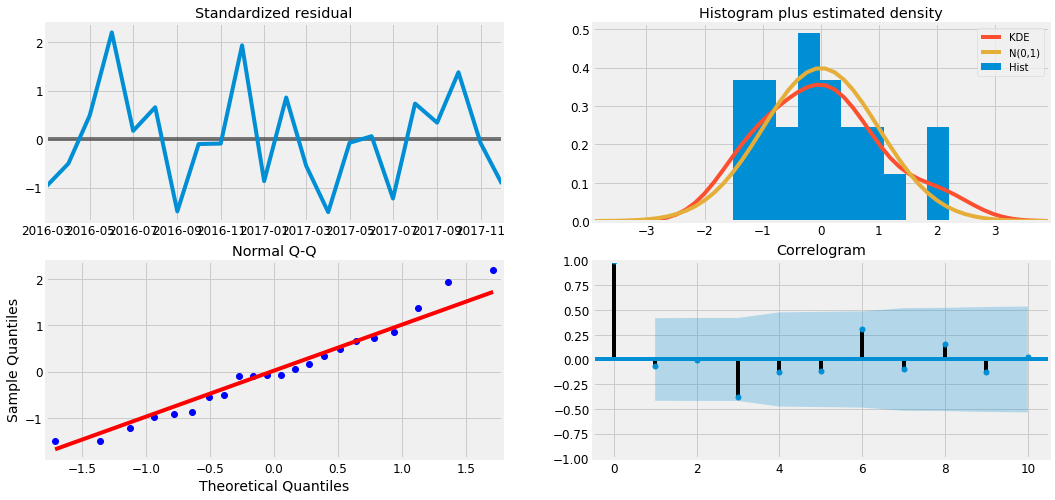

In [17]:
results.plot_diagnostics(figsize = (16, 8))
plt.show()

## Tahminleri doğrulama

Tahminlerimizin doğruluğunu anlamamıza yardımcı olmak için tahmin edilen satışları zaman serisinin gerçek satışlarıyla karşılaştırırız. Ve tahminlerin 2017-07-01'de verilerin sonuna kadar başlayacağını belirleriz.

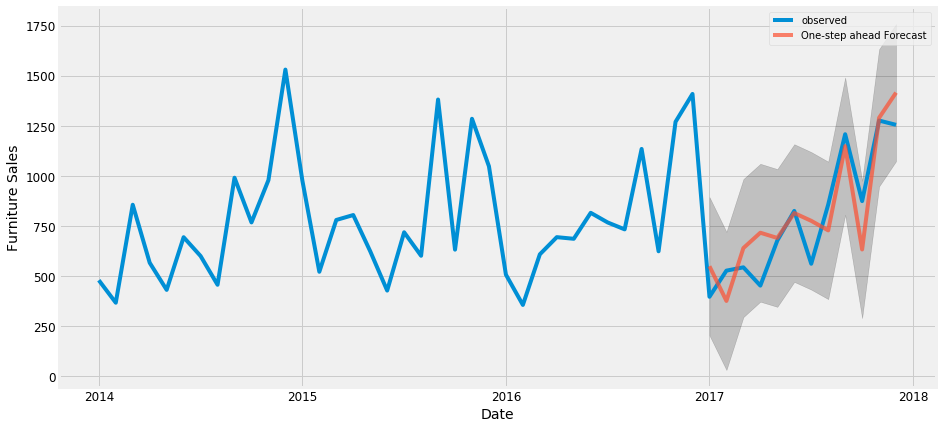

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label = 'One-step ahead Forecast', alpha = .7, figsize = (14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

Çizgi grafiği, gözlemlenen değerlere kıyasla kayan tahmini öngörüyü gösteriyor. Genel olarak tahminlerimiz gerçek değerlerle çok iyi bir uyum içindedir, bir yükseliş eğiliminin yılın başından itibaren başladığını göstermektedir.

In [19]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Ortalama kare hatasının (MSE) hesaplanması
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Tahminlerimizin Ortalama Kare Hatası (MSE) {}'.format(round(mse, 2)))

Tahminlerimizin Ortalama Kare Hatası (MSE) 22993.57


In [20]:
print('Tahminlerimizin Kök Ortalama Kare Hatası (RMSE) {}'.format(round(np.sqrt(mse), 2)))

Tahminlerimizin Kök Ortalama Kare Hatası (RMSE) 151.64


İstatistiklerde bir tahmincinin ortalama kare hatası (MSE), hataların karelerinin ortalamasını ölçer. Diğer bir değişle tahmini değerler ile tahmin edilenler arasındaki ortalama kare farkı. MSE, bir tahmincinin kalitesinin bir ölçüsüdür. Her zaman negatif değildir ve MSE ne kadar küçük olursa en uygun çizgiyi (ideal tahmini) bulmaya o kadar yakın oluruz.

Kök ortalama kare hatası ise (RMSE) modelimizin __gerçek satışların 151.64'ünde belirlenen testteki ortalama günlük mobilya satışlarını tahmin edebildiğini__ söylüyor. Günlük mobilya satışlarımız da 400 ile 1200 arasında değişmektedir. Bu sonuç gösteriyorki oldukça iyi bir modele sahibiz.  

## Tahminleri üretmek ve görselleştirmek

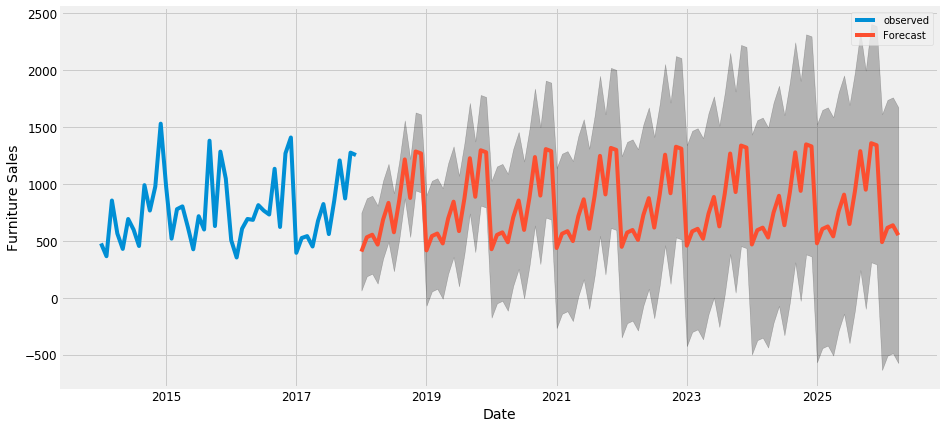

In [21]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label = 'observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax=ax, label = 'Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Modelimiz açıkça mevsimsellik (seasonality) mobilya satışlarını yakaladı. Geleceği daha fazla tahmin ettiğimiz gibi değerlerimizin daha az güvenilir olması doğaldır. Bu modelimizin ürettiği güven aralıkları ile yansıtılır, bu da geleceğe doğru ilerledikçe daha da büyür.

Mobilya için yukarıdaki zaman serisi analizi bizi diğer kategoriler hakkında meraklı yapıyor olabilir. Ve onlar diğer fazla (uzatma) zamanlarda birbirleriyle nasıl bir ilişki içindeler. Bu nedenle biz zaman serisi için mobilya ve ofis malzeme satışlarının karşılaştıracağız. 

## Zaman serisi karşılaştırma mobilya satışı ve Ofis malzemeleri 


### Veri ön işleme (Data Preprocessing)

In [22]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

Verilerimize göre yıllar içinde Mobilya'ya göre ofis malzemelerinin satışı daha fazla sayıdadır.

In [23]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [24]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis = 1, inplace = True)
office.drop(cols, axis = 1, inplace = True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

Verilere hızlı bir göz atalım.

In [25]:
furniture.head()

Order Date     Sales
0 2014-01-06  2573.820
1 2014-01-07    76.728
2 2014-01-10    51.940
3 2014-01-11     9.940
4 2014-01-13   879.939

In [26]:
office.head()

Order Date    Sales
0 2014-01-03   16.448
1 2014-01-04  288.060
2 2014-01-05   19.536
3 2014-01-06  685.340
4 2014-01-07   10.430

### Veri keşfi-araması (Data exploration) 

İki kategorinin de satışlarını aynı dönemde karşılaştıracağız. Bu iki veri çerçevesini bir araya getirmek ve bu iki kategorinin zaman serisini tek bir grafik içine çizmek anlamına geliyor.  

In [27]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how = 'inner', on = 'Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

Order Date  furniture_sales  office_sales
0 2014-01-01       480.194231    285.357647
1 2014-02-01       367.931600     63.042588
2 2014-03-01       857.291529    391.176318
3 2014-04-01       567.488357    464.794750
4 2014-05-01       432.049188    324.346545

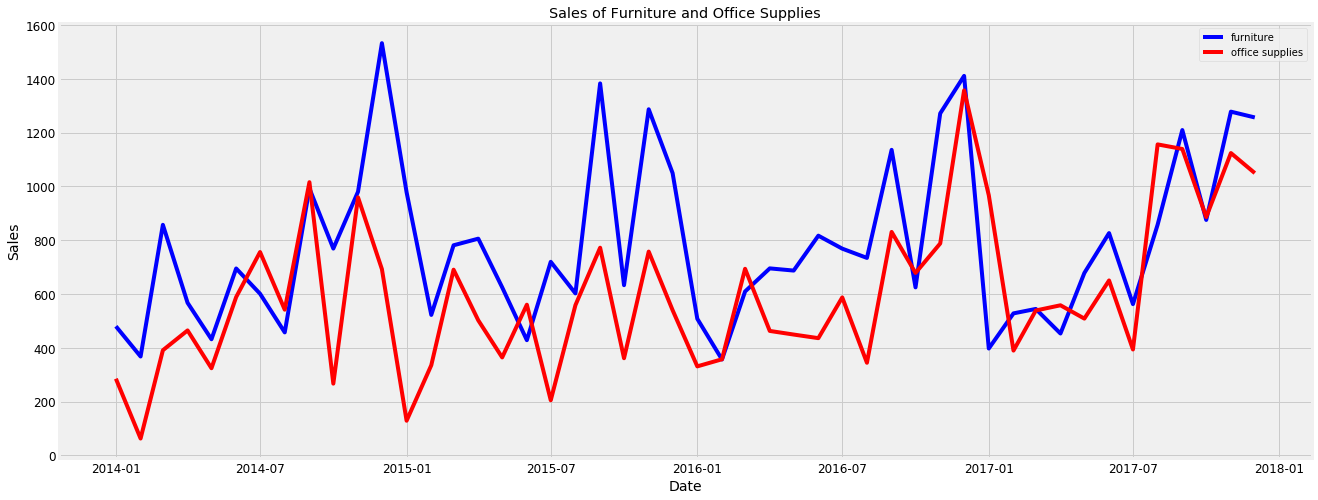

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

Mobilya ve ofis malzemeleri satışlarının benzer mevsimsel bir model paylaştığını gözlemliyoruz. Yılın başlarında iki kategoriden her ikisi için de sezon kapandı. Yaz aylarında ofis malzemeleri için de çok sessiz görünüyor.   

Buna ek olarak mobilya satışları için ortalama günlük satışlar ayların çoğunda ofis malzemelerine göre daha yüksektir. Mobilyanın değeri ofis malzemelerinin değerinden çok daha yüksek olması gerektiğinden anlaşılabilir bir durumdur.    

Bazen ofis malzemeleri günlük ortalama satışlarda mobilya satışlarını geçti. Ofis malzemelerinin satışlarının mobilyaların satışlarını ilk kez ne zaman aştığını öğrenelim.

In [29]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Ofis malzeme satışlarının ilk defa mobilya satışlarından daha yüksek satış yaptığı tarih {}.".format(first_date.date()))


Ofis malzeme satışlarının ilk defa mobilya satışlarından daha yüksek satış yaptığı tarih 2014-07-01.


__Temmuz 2014 oldu.__

Ofis malzemelerinin büyümesi biraz daha güçlü görünse de hem mobilya hem de ofis malzemeleri için satışların zamanla doğrusal olarak arttığını söyleyebiliriz.

> Mobilya için en kötü ay "Nisan", en iyi ay ise "Aralık"'dır.      

> Ofis malzemeleri için en kötü ay "Şubat", en iyi ay ise "Kasım"'dır.   

### Prophet ile Zaman Serisi Modellemesi

Facebook tarafından 2017 yılında piyasaya sürülen öngörme aracı Prophet, lineer olmayan trendlerin yıllık, haftalık ve günlük gibi farklı zaman ölçeklerinde modelleri gösteren zaman serilerini analiz etmek için tasarlanmıştır.    

Aynı zamanda tatil günlerinin bir zaman serisi üzerindeki etkilerini modelleme ve özel değişim noktalarını uygulama konusunda gelişmiş yeteneklere sahiptir.

Prophet eksik veriye ve trenddeki değişimlere karşı dayanıklıdır ve genellikle aykırı değerleri iyi idare eder.

Prophet ile ilgili detaylı bilgiye aşağıdaki weblink'lerden ulaşılabilir.

> https://facebook.github.io/prophet/

> https://github.com/facebook/prophet

### Referanslar

> https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3